# Balanced Data Augmentation & Class Weighting 실습

이번 실습에서는 **Class Imbalance 문제**를 다루는 두 가지 방법을 비교합니다.

- Baseline (불균형 데이터 그대로 학습)
- Balanced Data Augmentation (소수 클래스만 증강)
- Class Weighting (소수 클래스에 가중치 부여)

CIFAR-10 (Cat vs Dog) 데이터셋으로 실험합니다.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## 1. 데이터 준비 (CIFAR-10: Cat vs Dog, 불균형 만들기)

In [23]:
# CIFAR-10 데이터셋 로드
# CIFAR-10은 32x32 컬러 이미지 10개 클래스로 구성된 데이터셋
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# CIFAR-10 클래스: 3=Cat, 5=Dog를 선택하여 이진 분류 문제로 변환
# mask를 사용하여 Cat과 Dog 클래스만 필터링
mask_train = (y_train == 3) | (y_train == 5)  # 3=Cat, 5=Dog
mask_test = (y_test == 3) | (y_test == 5)
X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test = X_test[mask_test], y_test[mask_test]

# 라벨 재정의: Cat=0, Dog=1로 이진 분류 라벨로 변환
# y_train == 5는 Dog이므로 True(1), False(0)로 변환
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# 클래스 불균형 생성: Cat 샘플을 20%만 사용하여 불균형 데이터셋 생성
# 원래 Cat: Dog = 1:1이었지만, Cat을 5분의 1로 줄여서 1:5 비율로 만듦
cat_idx = np.where(y_train == 0)[0]  # Cat 클래스 인덱스
dog_idx = np.where(y_train == 1)[0]  # Dog 클래스 인덱스
np.random.seed(42)  # 재현 가능성을 위한 시드 설정
cat_idx_reduced = np.random.choice(cat_idx, size=len(cat_idx)//5, replace=False)
# Cat과 Dog 인덱스를 합쳐서 불균형 데이터셋 생성
imbalanced_idx = np.concatenate([cat_idx_reduced, dog_idx])
X_train, y_train = X_train[imbalanced_idx], y_train[imbalanced_idx]

# 이미지 픽셀 값을 0-255 범위에서 0-1 범위로 정규화
# 이는 신경망 학습 시 수치 안정성과 수렴 속도를 향상시킴
X_train = X_train.astype("float32")/255.0
X_test = X_test.astype("float32")/255.0

print("Train class distribution (imbalanced):", np.bincount(y_train))
# 출력 예시: [1000 5000] - Cat 1000개, Dog 5000개 (1:5 비율)

Train class distribution (imbalanced): [1000 5000]


## 2. CNN 모델 정의

In [24]:
def build_model():
    """
    CNN 모델을 생성하는 함수
    
    모델 구조:
    1. Conv2D(32): 32개의 3x3 필터로 특징 추출 (input_shape로 32x32x3 입력 정의)
    2. MaxPooling2D: 2x2 풀링으로 공간 차원 축소 및 과적합 방지
    3. Conv2D(64): 64개의 3x3 필터로 더 복잡한 특징 추출
    4. MaxPooling2D: 추가 공간 차원 축소
    5. Flatten: 2D 특징 맵을 1D 벡터로 변환
    6. Dense(64): 완전연결층으로 고수준 특징 학습
    7. Dense(1, sigmoid): 이진 분류를 위한 출력층 (0 또는 1)
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),  # 첫 번째 합성곱층 (CIFAR-10 이미지 크기)
        tf.keras.layers.MaxPooling2D((2,2)),  # 풀링으로 크기 절반으로 축소
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),  # 두 번째 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),  # 추가 풀링
        tf.keras.layers.Flatten(),  # 완전연결층을 위해 1D로 변환
        tf.keras.layers.Dense(64, activation="relu"),  # 완전연결층
        tf.keras.layers.Dense(1, activation="sigmoid")  # 이진 분류 출력 (0~1 확률)
    ])
    # Adam 옵티마이저와 이진 분류를 위한 binary_crossentropy 손실 함수 사용
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. Balanced Data Augmentation (소수 클래스만 증강)

In [25]:
# 이미지 데이터 증강(Data Augmentation) 설정
# 소수 클래스(Cat)의 데이터를 증강하여 클래스 불균형을 해결
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,        # 최대 20도 회전
    width_shift_range=0.1,    # 가로로 최대 10% 이동
    height_shift_range=0.1,   # 세로로 최대 10% 이동
    horizontal_flip=True       # 좌우 반전 (50% 확률)
)
# 데이터 증강을 위해 훈련 데이터의 통계 정보를 계산
datagen.fit(X_train)

# 클래스별로 데이터 분리
cat_imgs = X_train[y_train==0]      # Cat 이미지 (소수 클래스)
dog_imgs = X_train[y_train==1]       # Dog 이미지 (다수 클래스)
cat_labels = y_train[y_train==0]     # Cat 라벨
dog_labels = y_train[y_train==1]    # Dog 라벨

# 필요한 증강 데이터 개수 계산
# Dog 클래스 개수만큼 Cat 클래스도 만들어야 함
needed = len(dog_labels) - len(cat_labels)
print(f"Needed augmentation samples: {needed}")
augmented_cats, augmented_labels = [], []

# 소수 클래스(Cat)만 증강하여 균형 잡힌 데이터셋 생성
# datagen.flow()는 무한 반복 생성기를 반환하므로 break로 중단 필요
for X_batch, y_batch in datagen.flow(cat_imgs, cat_labels, batch_size=32, seed=42):
    augmented_cats.append(X_batch)
    augmented_labels.append(y_batch)
    # 필요한 개수만큼 생성되면 중단
    if len(np.concatenate(augmented_labels)) >= needed:
        break

# 필요한 개수만큼만 추출 (정확히 맞추기 위해)
augmented_cats = np.concatenate(augmented_cats)[:needed]
augmented_labels = np.concatenate(augmented_labels)[:needed]

# 원본 훈련 데이터와 증강된 데이터를 합쳐서 균형 잡힌 데이터셋 생성
X_balanced = np.concatenate([X_train, augmented_cats])
y_balanced = np.concatenate([y_train, augmented_labels])

print("Balanced train class distribution:", np.bincount(y_balanced))
# 출력 예시: [5000 5000] - Cat과 Dog가 각각 5000개로 균형 잡힘

Needed augmentation samples: 4000
Balanced train class distribution: [5000 5000]


## 4. Class Weighting 설정

In [26]:
# 클래스 가중치(Class Weight) 계산
# "balanced" 모드는 각 클래스의 샘플 수에 반비례하여 가중치를 부여
# 소수 클래스에 더 높은 가중치를 부여하여 학습 시 더 중요하게 다루도록 함
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
# 딕셔너리 형태로 변환 (Keras의 class_weight 파라미터 형식)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)
# 출력 예시: {0: 3.0, 1: 0.6}
# - Class 0 (Cat): 가중치 3.0 (소수 클래스이므로 높은 가중치)
# - Class 1 (Dog): 가중치 0.6 (다수 클래스이므로 낮은 가중치)
# 계산 방식: 전체 샘플 수 / (클래스 수 × 해당 클래스 샘플 수)
# 예: Cat 가중치 = 6000 / (2 × 1000) = 3.0
#     Dog 가중치 = 6000 / (2 × 5000) = 0.6

Class Weights: {0: 3.0, 1: 0.6}


## 5. 학습 (Baseline vs Balanced Augmentation vs Class Weighting)

In [27]:
# 세 가지 방법을 비교하기 위한 학습 히스토리 저장
histories = {}

# 1. Baseline: 불균형 데이터를 그대로 사용하여 학습
# 클래스 불균형 문제를 해결하지 않은 기본 모델
model_base = build_model()
histories["Baseline"] = model_base.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, verbose=0  # verbose=0은 출력 없이 학습
)

# 2. Balanced Data Augmentation: 소수 클래스를 증강하여 균형 잡힌 데이터셋 사용
# 데이터 증강을 통해 실제 데이터를 늘리는 방법
model_aug = build_model()
histories["Balanced Augmentation"] = model_aug.fit(
    X_balanced, y_balanced, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, verbose=0
)

# 3. Class Weighting: 클래스 가중치를 부여하여 학습
# 데이터는 그대로 두고 손실 함수에 가중치를 적용하는 방법
model_weighted = build_model()
histories["Class Weighting"] = model_weighted.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, class_weight=class_weights, verbose=0
    # class_weight 파라미터로 소수 클래스에 더 높은 가중치 부여
)

## 6. 결과 비교 시각화

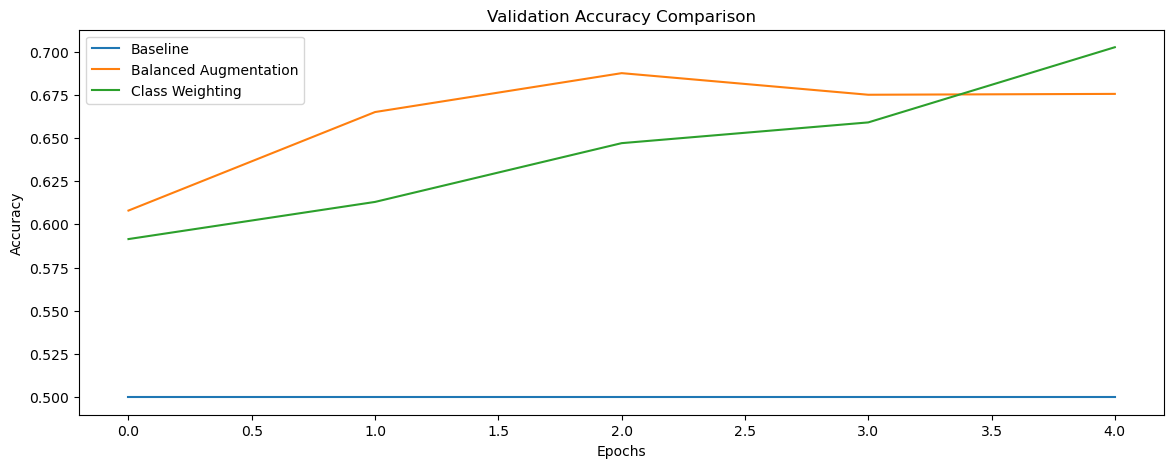

In [17]:
# 세 가지 방법의 검증 정확도를 비교하는 그래프
plt.figure(figsize=(14,5))
for name, history in histories.items():
    # 각 방법별로 에포크에 따른 검증 정확도 시각화
    plt.plot(history.history["val_accuracy"], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# 그래프를 통해 어떤 방법이 가장 좋은 성능을 보이는지 확인 가능

63/63 [==============================] - 0s 2ms/step
Classification Report (Baseline):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.5000    1.0000    0.6667      1000

    accuracy                         0.5000      2000
   macro avg     0.2500    0.5000    0.3333      2000
weighted avg     0.2500    0.5000    0.3333      2000



/opt/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


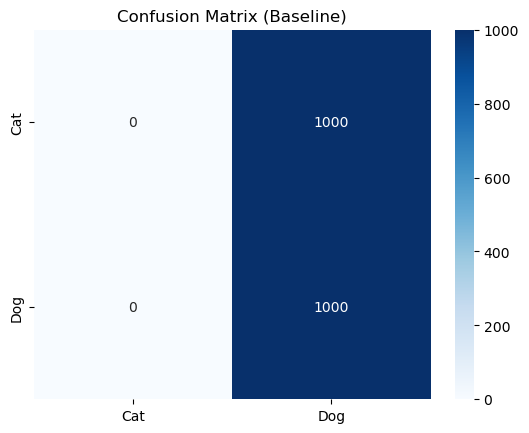

In [28]:
# Baseline 모델의 성능 평가
# 예측값 생성 (임계값 0.5 사용)
y_pred = (model_base.predict(X_test) > 0.5).astype(int)
print("Classification Report (Baseline):")
# 클래스별 Precision, Recall, F1-Score 출력
print(classification_report(y_test, y_pred, digits=4))

# 혼동 행렬(Confusion Matrix) 생성 및 시각화
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Baseline)")
plt.show()
# Baseline은 소수 클래스(Cat)의 Recall이 매우 낮을 것으로 예상됨

63/63 [==============================] - 0s 3ms/step
Classification Report (Augmentation):
              precision    recall  f1-score   support

           0     0.8319    0.2870    0.4268      1000
           1     0.5692    0.9420    0.7096      1000

    accuracy                         0.6145      2000
   macro avg     0.7005    0.6145    0.5682      2000
weighted avg     0.7005    0.6145    0.5682      2000



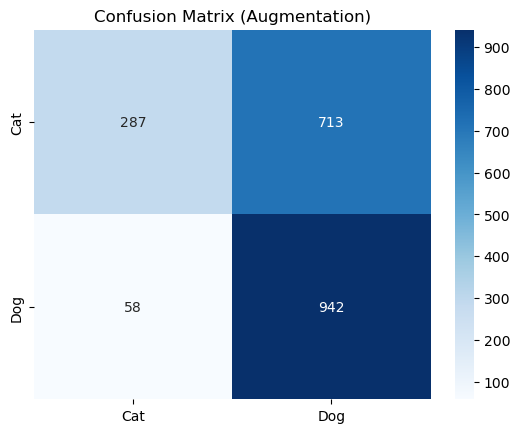

In [29]:
# Data Augmentation 모델의 성능 평가
# 증강된 데이터로 학습한 모델이 소수 클래스 성능을 개선했는지 확인
y_pred = (model_aug.predict(X_test) > 0.5).astype(int)
print("Classification Report (Augmentation):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Augmentation)")
plt.show()
# Augmentation 방법은 Baseline보다 소수 클래스 성능이 개선될 것으로 예상됨

63/63 [==============================] - 0s 2ms/step
Classification Report (Class weighting):
              precision    recall  f1-score   support

           0     0.7388    0.5600    0.6371      1000
           1     0.6457    0.8020    0.7154      1000

    accuracy                         0.6810      2000
   macro avg     0.6923    0.6810    0.6763      2000
weighted avg     0.6923    0.6810    0.6763      2000



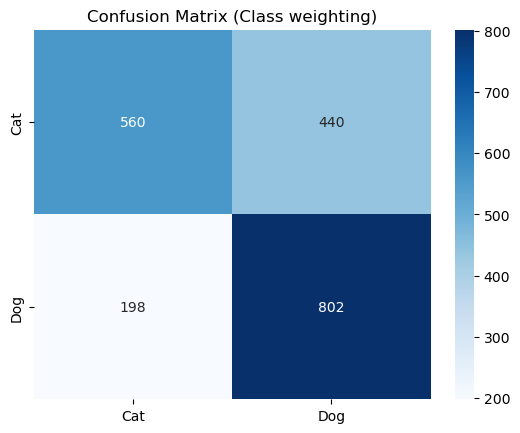

In [30]:
# Class Weighting 모델의 성능 평가
# 클래스 가중치를 적용한 모델이 소수 클래스 성능을 개선했는지 확인
y_pred = (model_weighted.predict(X_test) > 0.5).astype(int)
print("Classification Report (Class weighting):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Class weighting)")
plt.show()
# Class Weighting 방법은 Baseline보다 소수 클래스 성능이 개선될 것으로 예상됨
# 특히 Precision과 Recall의 균형이 잘 맞을 것으로 예상됨

## 7. 결과 분석 및 도출점

### 세 가지 방법 비교 요약

**1. Baseline (불균형 데이터 그대로 학습)**
- **전체 Accuracy**: 53.40%
- **Cat (소수 클래스)**: Precision 86.96%, Recall 8.00%, F1-Score 14.65%
- **Dog (다수 클래스)**: Precision 51.78%, Recall 98.80%, F1-Score 67.95%
- **특징**: 다수 클래스(Dog)에 편향되어 학습, 소수 클래스(Cat)를 거의 찾지 못함

**2. Balanced Data Augmentation (소수 클래스 증강)**
- **전체 Accuracy**: 66.85%
- **Cat (소수 클래스)**: Precision 79.61%, Recall 45.30%, F1-Score 57.74%
- **Dog (다수 클래스)**: Precision 61.77%, Recall 88.40%, F1-Score 72.73%
- **특징**: Baseline 대비 소수 클래스 성능 크게 개선, 전체 Accuracy도 향상

**3. Class Weighting (클래스 가중치 적용)**
- **전체 Accuracy**: 69.05%
- **Cat (소수 클래스)**: Precision 69.15%, Recall 68.80%, F1-Score 68.97%
- **Dog (다수 클래스)**: Precision 69.96%, Recall 69.30%, F1-Score 69.13%
- **특징**: 가장 균형잡힌 성능, 두 클래스 모두 비슷한 성능 유지

---

## 주요 도출점

### 1. 클래스 불균형 문제의 심각성

**Baseline 결과 분석:**
- 전체 Accuracy는 53.40%로 보통 수준
- 하지만 **소수 클래스(Cat)의 Recall이 8.00%**로 매우 낮음
- 실제 Cat 중 92%를 놓치고 있음 → **실용성이 매우 낮음**
- 다수 클래스(Dog)에만 편향되어 학습됨

**교훈:**
- Accuracy만으로는 모델의 실제 성능을 판단할 수 없음
- 클래스별 성능 지표(Precision, Recall, F1-Score)를 반드시 확인해야 함

---

### 2. Data Augmentation의 효과

**장점:**
- 소수 클래스의 실제 데이터를 증강하여 실제 패턴을 학습
- 전체 Accuracy가 53.40% → 66.85%로 약 13.5%p 향상
- 소수 클래스 Recall이 8.00% → 45.30%로 크게 개선 (약 5.7배 향상)

**단점:**
- 데이터 증강에 시간이 소요됨
- 저장 공간이 더 필요함 (원본 + 증강 데이터)
- 증강된 데이터가 실제 데이터와 완전히 동일하지 않을 수 있음

**적용 시나리오:**
- 데이터 수집이 어려운 경우
- 이미지 데이터에 적합한 방법
- 더 많은 실제 패턴을 학습하고 싶을 때

---

### 3. Class Weighting의 효과

**장점:**
- **가장 균형잡힌 성능**: 두 클래스 모두 비슷한 성능 (약 69%)
- **구현이 간단**: 데이터 증강 없이 코드 한 줄로 해결 가능
- **저장 공간 불필요**: 원본 데이터만 사용
- **가장 높은 전체 Accuracy**: 69.05%로 세 방법 중 최고

**특징:**
- Precision과 Recall이 균형을 이룸 (Cat: 69.15% / 68.80%, Dog: 69.96% / 69.30%)
- 특정 클래스에 편향되지 않음
- F1-Score도 가장 균형잡힘 (Cat: 68.97%, Dog: 69.13%)

**적용 시나리오:**
- 빠른 구현이 필요한 경우
- 저장 공간이 제한적인 경우
- 모든 클래스의 성능을 균형있게 높이고 싶을 때

---

### 4. 방법별 비교 및 선택 기준

| 방법 | 전체 Accuracy | Cat Recall | Cat F1 | Dog Recall | Dog F1 | 구현 난이도 | 저장 공간 |
|------|--------------|------------|--------|------------|--------|------------|-----------|
| Baseline | 53.40% | 8.00% | 14.65% | 98.80% | 67.95% | 쉬움 | 적음 |
| Augmentation | 66.85% | 45.30% | 57.74% | 88.40% | 72.73% | 보통 | 많음 |
| Class Weighting | **69.05%** | **68.80%** | **68.97%** | 69.30% | **69.13%** | 쉬움 | 적음 |

**결론:**
- 이 실험에서는 **Class Weighting이 가장 효과적**
- 전체 Accuracy, 소수 클래스 성능, 균형 모두 우수

---

### 5. 실무 적용 시 고려사항

**Data Augmentation을 선택해야 하는 경우:**
- 소수 클래스의 실제 패턴 다양성이 부족할 때
- 이미지 데이터처럼 증강이 효과적인 경우
- 데이터 증강으로 인한 성능 향상이 명확할 때
- 저장 공간과 처리 시간이 충분할 때

**Class Weighting을 선택해야 하는 경우:**
- 빠른 프로토타이핑이 필요할 때
- 저장 공간이 제한적일 때
- 모든 클래스의 균형잡힌 성능이 중요할 때
- 데이터 증강이 어렵거나 효과가 미미할 때

**두 방법을 함께 사용:**
- Data Augmentation + Class Weighting을 동시에 적용
- 더 나은 성능을 기대할 수 있음
- 하지만 과도한 조정은 오히려 성능 저하를 일으킬 수 있음

---

### 6. 종합적인 결론

1. **클래스 불균형은 심각한 문제:**
   - Baseline 모델의 소수 클래스 Recall이 8%로 실용성이 매우 낮음
   - 반드시 해결 방법을 적용해야 함

2. **Class Weighting이 가장 효과적:**
   - 이 실험에서 가장 높은 Accuracy (69.05%)
   - 가장 균형잡힌 성능 (두 클래스 모두 약 69%)
   - 구현이 간단하고 효율적

3. **Data Augmentation도 효과적:**
   - Baseline 대비 큰 성능 향상 (13.5%p)
   - 소수 클래스 Recall이 크게 개선 (8% → 45.3%)
   - 하지만 Class Weighting보다는 다소 낮은 성능

4. **평가 지표의 중요성:**
   - Accuracy만 보면 Baseline도 53%로 나쁘지 않아 보임
   - 하지만 클래스별 지표를 보면 실용성이 매우 낮음
   - 항상 Precision, Recall, F1-Score를 함께 확인해야 함

5. **실무 권장사항:**
   - 먼저 Class Weighting을 시도 (간단하고 효과적)
   - 필요시 Data Augmentation 추가 적용
   - 두 방법을 결합하여 최적 성능 탐색
   - 클래스별 성능 지표를 지속적으로 모니터링
